<a href="https://colab.research.google.com/github/KangHwan-Cha/MyStudy/blob/main/TensorProject/Category5A__Sequence, Time Series-training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### import

In [2]:
import csv
import tensorflow as tf
import numpy as np
import urllib

In [3]:
from tensorflow.keras.layers import Dense, LSTM, Lambda, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

In [4]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/Sunspots.csv'
urllib.request.urlretrieve(url, 'sunspots.csv')

('sunspots.csv', <http.client.HTTPMessage at 0x1d7b858b310>)

In [21]:
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    i = 0
    # for i in range(1): next(reader)
    for row in reader:
        print(row)
        i+=1
        if i > 10: break

['', 'Date', 'Monthly Mean Total Sunspot Number']
['0', '1749-01-31', '96.7']
['1', '1749-02-28', '104.3']
['2', '1749-03-31', '116.7']
['3', '1749-04-30', '92.8']
['4', '1749-05-31', '141.7']
['5', '1749-06-30', '139.2']
['6', '1749-07-31', '158.0']
['7', '1749-08-31', '110.5']
['8', '1749-09-30', '126.5']
['9', '1749-10-31', '125.8']


In [18]:
sunspots = []
time_step = []
with open('sunspots.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        sunspots.append(float(row[2]))
        time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
series.shape, time.shape

((3235,), (3235,))

In [19]:
split_time = 3000
time_train = time[:split_time]
time_valid = time[split_time:]

x_train = series[:split_time]
x_valid = series[split_time:]

In [22]:
window_size = 30
batch_size = 32
shuffle_size = 1000

In [23]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [24]:
train_set = windowed_dataset(x_train,
                            window_size=window_size,
                            batch_size=batch_size,
                            shuffle_buffer=shuffle_size)

validation_set = windowed_dataset(x_valid,
                                window_size=window_size,
                                batch_size=batch_size,
                                shuffle_buffer=shuffle_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
model = Sequential([
    Conv1D(60, kernel_size=5,
            padding="causal",
            activation='relu',
            input_shape=[None, 1]),
    LSTM(60, return_sequences=True),
    LSTM(60, return_sequences=True),
    Dense(30, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1),
    Lambda(lambda x: x * 400)
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 60)          360       
                                                                 
 lstm_2 (LSTM)               (None, None, 60)          29040     
                                                                 
 lstm_3 (LSTM)               (None, None, 60)          29040     
                                                                 
 dense_1 (Dense)             (None, None, 30)          1830      
                                                                 
 dense_2 (Dense)             (None, None, 10)          310       
                                                                 
 dense_3 (Dense)             (None, None, 1)           11        
                                                                 
 lambda (Lambda)             (None, None, 1)           0

In [30]:
optimizer = SGD(learning_rate=0.00001, momentum=0.9)
loss = Huber()
model.compile(loss=loss, optimizer=optimizer, metrics=["mae"])

In [34]:
checkpoint_path = 'tmp_checkpoint.cktp'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='val_mae',
                            verbose=1)

In [35]:
epochs = 100
history = model.fit(train_set,
                    validation_data=(validation_set),
                    epochs=epochs,
                    callbacks=[checkpoint])

Epoch 1/100
     92/Unknown - 5s 18ms/step - loss: 29.5898 - mae: 30.0850
Epoch 1: val_mae improved from inf to 27.79605, saving model to tmp_checkpoint.cktp
93/93 [==============================] - 7s 42ms/step - loss: 29.5379 - mae: 30.0330 - val_loss: 27.3016 - val_mae: 27.7960
Epoch 2/100
92/93 [============================>.] - ETA: 0s - loss: 21.2789 - mae: 21.7720
Epoch 2: val_mae improved from 27.79605 to 16.98994, saving model to tmp_checkpoint.cktp
93/93 [==============================] - 2s 20ms/step - loss: 21.2999 - mae: 21.7929 - val_loss: 16.4995 - val_mae: 16.9899
Epoch 3/100
93/93 [==============================] - ETA: 0s - loss: 19.5712 - mae: 20.0641
Epoch 3: val_mae improved from 16.98994 to 15.52753, saving model to tmp_checkpoint.cktp
93/93 [==============================] - 2s 21ms/step - loss: 19.5712 - mae: 20.0641 - val_loss: 15.0367 - val_mae: 15.5275
Epoch 4/100
91/93 [============================>.] - ETA: 0s - loss: 18.7568 - mae: 19.2492
Epoch 4: val_mae

In [36]:
model.load_weights(checkpoint_path)

### Visualization

In [37]:
import matplotlib.pyplot as plt

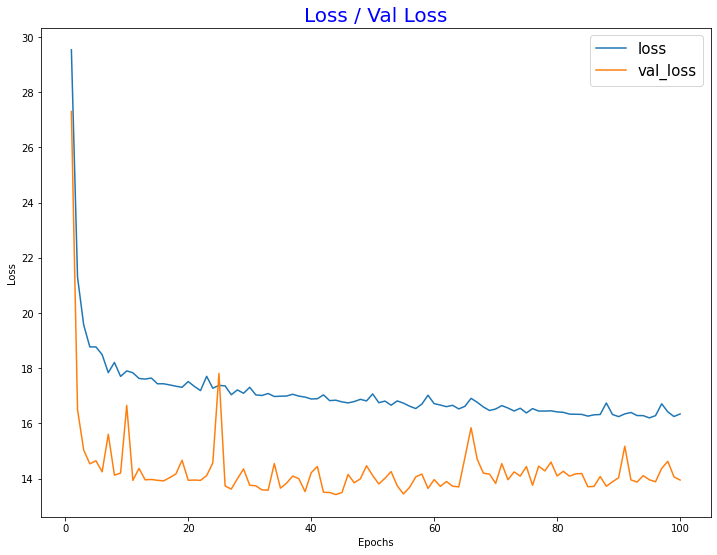

In [42]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.plot(np.arange(1, epochs+1), history.history['val_loss'])
plt.title('Loss / Val Loss', fontsize=20, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['loss', 'val_loss'], fontsize=15)
plt.show()

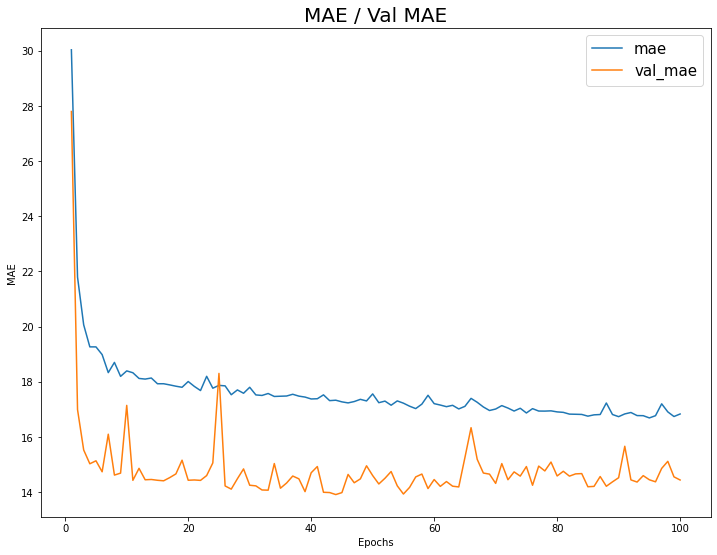

In [43]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['mae'])
plt.plot(np.arange(1, epochs+1), history.history['val_mae'])
plt.title('MAE / Val MAE', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['mae', 'val_mae'], fontsize=15)
plt.show()